In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import datasets
from custom_models import cnns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

%reload_ext autoreload
%autoreload 2

wandb_api.login()
api = wandb.Api()
run_name = "2d5bpjk6"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [2]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

model_script = run.file("model_script.txt")
model_script = model_script.download(root=root_path / run.name, replace=True)
model_script.seek(0)

datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path / run.name, replace=True)
datamodule_script.seek(0)

checkpoint = run.file("epoch=611-val_loss=0.044.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
model_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)
with open(datamodule_script.name, "r") as file:
    exec(file.read())


In [3]:
class PreTrainedVGG(cnns.BaseModel):
    def __init__(self, config, scaler=None):
        super().__init__(config)

        self.config = config
        self.config["model_type"] = type(self)
        self.scaler = scaler

        self.configure_model()
        self.configure_criterion()
        self.configure_metrics()

    def configure_model(self):
        assert self.config["total_layers"] >= self.config["fixed_layers"]
        vgg = pretrained_models.vgg16_bn(pretrained=True)
        self.layers = nn.Sequential(
            *(list(vgg.features.children())[: self.config["total_layers"]])
        )
        for idx, child in enumerate(self.layers.children()):
            if idx < self.config["fixed_layers"] and isinstance(child, nn.Conv2d):
                for param in child.parameters():
                    param.requires_grad = False
#             else:
#                 reset_parameters = getattr(child, "reset_parameters", None)
#                 if callable(reset_parameters):
#                     child.reset_parameters()
#         self.max_pool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
        nb_channels, height, width = (
            self.layers(
                torch.rand(
                    (1, 3, self.config["input_width"], config["nb_image_per_axis"]*self.config["input_width"])
                )
            )
            .squeeze()
            .shape
        )
        input_fc = int(height * width * nb_channels)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_fc, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=28),
        )

    def forward(self, x):
        x = self.layers(x)
#         x = self.max_pool(x)
        x = self.linear_layers(x)
        return x
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        metrics = {name: metric(y, y_hat) for name, metric in self.metrics.items()}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        return metrics

    def configure_metrics(self):
        self.metrics = {
            "val_loss": self.criterion.to(self.config["device"]),
            "mae": torchmetrics.MeanAbsoluteError().to(self.config["device"]),
            "mape": torchmetrics.MeanAbsolutePercentageError().to(
                self.config["device"]
            ),
            "smape": torchmetrics.SymmetricMeanAbsolutePercentageError().to(
                self.config["device"]
            ),
            "r2_score": torchmetrics.R2Score(num_outputs=28).to(self.config["device"]),
            "cosine_similarity": torchmetrics.CosineSimilarity(reduction="mean").to(
                self.config["device"]
            ),
        }


In [4]:
class DataModuleV2(DataModule): 
    def setup(self, stage):
        if self.train_dataset is None or self.validation_dataset is None:
            self.init_df()
            
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            self.scaler.partial_fit(self.train_df.iloc[:, 1:-1])
            self.scaler.partial_fit(self.test_df.iloc[:, 1:-1])
            
            normalized_train_df = deepcopy(self.train_df)
            normalized_train_df.iloc[:, 1:-1] = self.scaler.transform(
                self.train_df.iloc[:, 1:-1]
            )
            normalized_test_df = deepcopy(self.test_df)
            normalized_test_df.iloc[:, 1:-1] = self.scaler.transform(
                self.test_df.iloc[:, 1:-1]
            )

            if self.train_dataset is None:
                self.train_dataset = datasets.NWidthStackedPhotosDataset(
                    normalized_train_df,
                    nb_image_per_axis=config["nb_image_per_axis"],
                    transform=self.transform,
                )
            if self.validation_dataset is None:
                self.validation_dataset = datasets.NWidthStackedPhotosDataset(
                    normalized_test_df,
                    nb_image_per_axis=config["nb_image_per_axis"],
                    transform=self.transform,
                )
            self.targets = self.test_df.iloc[:, 1:-1].to_numpy()


In [5]:
dm = DataModuleV2(config=config, repo_path=repo_path)
model = PreTrainedVGG.load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.cat([label for _, label in dm.val_dataloader()])


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
2022-11-09 13:19:16.040251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matias/RECVIS:
2022-11-09 13:19:16.042478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
print("VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS")
print(training.display_metrics(predictions[:, :], targets[:, :]))
print("VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS")
print(
    training.display_metrics(
        dm.scaler.inverse_transform(predictions)[:, :],
        dm.scaler.inverse_transform(targets)[:, :],
    )
)


VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS
cosine_similarity: 0.9936708211898804
r2_score: -inf
smape: 0.22147640585899353
mape: 193.08775329589844
mae: 0.0443536639213562
mse: 0.0048941620625555515
_______________________________________________________________
VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS
cosine_similarity: 0.999796986579895
r2_score: -inf
smape: 0.18228226900100708
mape: 0.5218631625175476
mae: 0.027662940323352814
mse: 0.006385892629623413
_______________________________________________________________


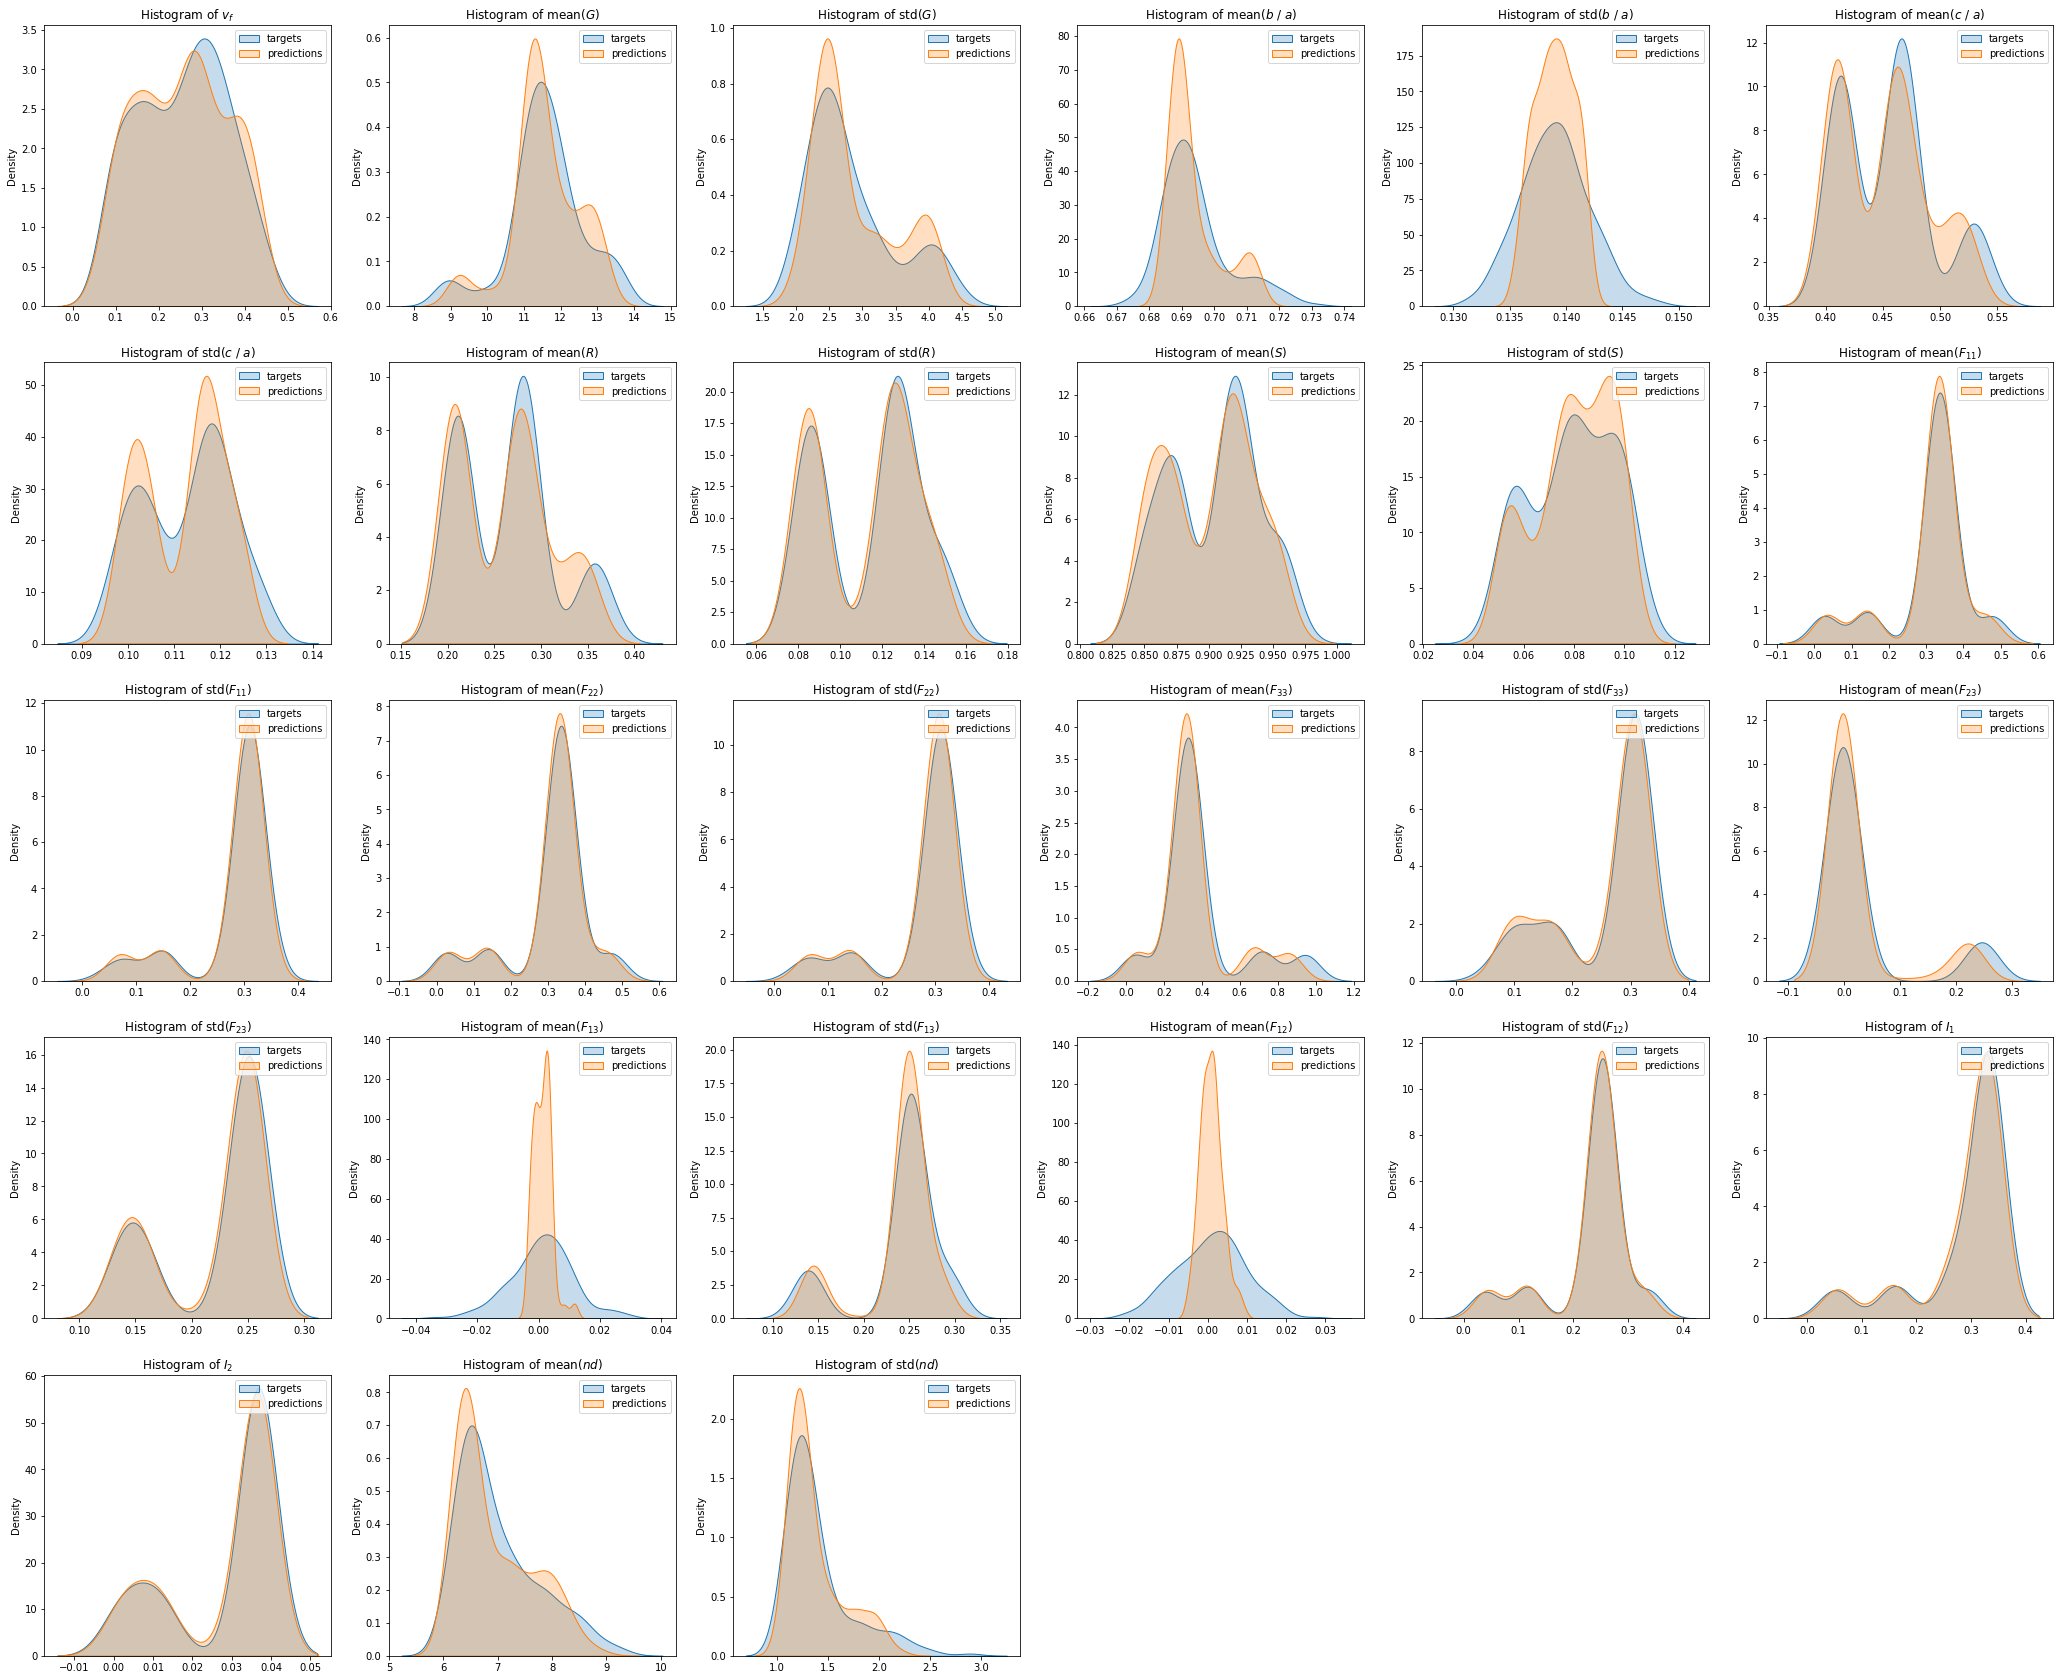

In [7]:
column_mapping = {
    "invariant-1": r"$I_1$",
    "invariant-2": r"$I_2$",
    "orientation-0_mean": r"mean($F_{11}$)",
    "orientation-1_mean": r"mean($F_{22}$)",
    "orientation-2_mean": r"mean($F_{33}$)",
    "orientation-3_mean": r"mean($F_{23}$)",
    "orientation-4_mean": r"mean($F_{13}$)",
    "orientation-5_mean": r"mean($F_{12}$)",
    "orientation-0_std": r"std($F_{11}$)",
    "orientation-1_std": r"std($F_{22}$)",
    "orientation-2_std": r"std($F_{33}$)",
    "orientation-3_std": r"std($F_{23}$)",
    "orientation-4_std": r"std($F_{13}$)",
    "orientation-5_std": r"std($F_{12}$)",
    "aspectratio-0_mean": r"mean($b$ / $a$)",
    "aspectratio-1_mean": r"mean($c$ / $a$)",
    "aspectratio-0_std": r"std($b$ / $a$)",
    "aspectratio-1_std": r"std($c$ / $a$)",
    "size_mean": r"mean($G$)",
    "size_std": r"std($G$)",
    "solidity_mean": r"mean($S$)",
    "solidity_std": r"std($S$)",
    "roundness_mean": r"mean($R$)",
    "roundness_std": r"std($R$)",
    "nearest_distance_mean": r"mean($nd$)",
    "nearest_distance_std": r"std($nd$)",
    "volume_fraction": r"$v_f$",
}

order_of_columns = [
    "volume_fraction",
    "size_mean",
    "size_std",
    "aspectratio-0_mean",
    "aspectratio-0_std",
    "aspectratio-1_mean",
    "aspectratio-1_std",
    "roundness_mean",
    "roundness_std",
    "solidity_mean",
    "solidity_std",
    "orientation-0_mean",
    "orientation-0_std",
    "orientation-1_mean",
    "orientation-1_std",
    "orientation-2_mean",
    "orientation-2_std",
    "orientation-3_mean",
    "orientation-3_std",
    "orientation-4_mean",
    "orientation-4_std",
    "orientation-5_mean",
    "orientation-5_std",
    "invariant-1",
    "invariant-2",
    "nearest_distance_mean",
    "nearest_distance_std",
]

unnormzalied_targets = pd.DataFrame(
    dm.scaler.inverse_transform(targets.cpu().numpy()),
    columns=dm.train_df.columns[1:-1],
)

unnormzalied_predictions = pd.DataFrame(
    dm.scaler.inverse_transform(predictions.cpu().numpy()),
    columns=dm.train_df.columns[1:-1],
)

fig, axs = plotting.plot_kde(
    unnormzalied_targets[order_of_columns],
    unnormzalied_predictions[order_of_columns],
    column_mapping=column_mapping,
)
plt.savefig("histogram.png", dpi=300, bbox_inches="tight")


AxesSubplot(0.125,0.125;0.775x0.755)


<AxesSubplot:>

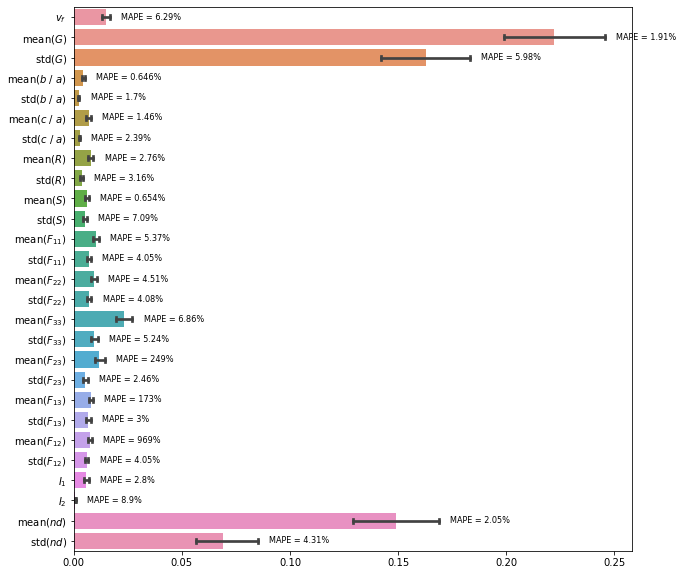

In [8]:
plotting.plot_horizontal_bars(
    unnormzalied_targets[order_of_columns],
    unnormzalied_predictions[order_of_columns],
    column_mapping,
)


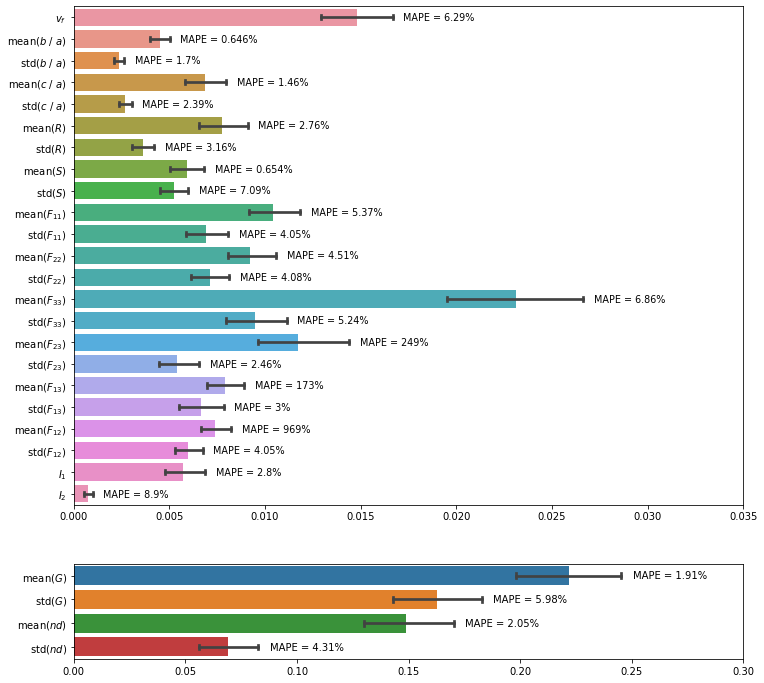

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={"height_ratios": [21, 4]})

order_of_columns_first_ax = [
    "volume_fraction",
    "aspectratio-0_mean",
    "aspectratio-0_std",
    "aspectratio-1_mean",
    "aspectratio-1_std",
    "roundness_mean",
    "roundness_std",
    "solidity_mean",
    "solidity_std",
    "orientation-0_mean",
    "orientation-0_std",
    "orientation-1_mean",
    "orientation-1_std",
    "orientation-2_mean",
    "orientation-2_std",
    "orientation-3_mean",
    "orientation-3_std",
    "orientation-4_mean",
    "orientation-4_std",
    "orientation-5_mean",
    "orientation-5_std",
    "invariant-1",
    "invariant-2",
]
order_of_columns_second_ax = [
    "size_mean",
    "size_std",
    "nearest_distance_mean",
    "nearest_distance_std",
]
plotting.plot_horizontal_bars(
    unnormzalied_targets[order_of_columns_first_ax],
    unnormzalied_predictions[order_of_columns_first_ax],
    column_mapping,
    axs[0],
)
plotting.plot_horizontal_bars(
    unnormzalied_targets[order_of_columns_second_ax],
    unnormzalied_predictions[order_of_columns_second_ax],
    column_mapping,
    axs[1],
)

axs[0].set_xlim(right=0.035)
axs[1].set_xlim(right=0.3)
plt.savefig("bars.png", dpi=300, bbox_inches="tight")

In [25]:
def compute_mae_per_descriptor(targets, predictions):
    return torch.mean(torch.abs(targets - predictions), axis=0).cpu().numpy()


def compute_average_correlation(df):
    corr_matrix = df.corr().to_numpy()
    return np.array(
        [
            np.mean(np.abs(np.delete(corr_matrix[i, :], i)))
            for i in range(len(corr_matrix))
        ]
    )


train_df = dm.train_df.drop(labels="id", axis=1)
mae_per_descriptor = compute_mae_per_descriptor(targets, predictions)
average_correlation = compute_average_correlation(train_df)

sorted_idx_mae = np.argsort(mae_per_descriptor)
print(f"Largest MAE on:\n\t{np.array(train_df.columns)[sorted_idx_mae][:4]}")

sorted_idx_corr = np.argsort(average_correlation)
print(f"Lowest correlation on:\n\t{np.array(train_df.columns)[sorted_idx_corr][:4]}")

idx_lowest_corr = np.argmin(average_correlation)
print(
    f"Average correlation of {np.array(train_df.columns)[idx_lowest_corr]}: {average_correlation[idx_lowest_corr]}"
)
print(
    f"Average correlation elsewhere {np.mean(np.delete(average_correlation, sorted_idx_corr[:-1]))}"
)


Largest MAE on:
	['orientation-1_mean' 'orientation-5_std' 'orientation-0_std'
 'orientation-3_std']
Lowest correlation on:
	['orientation-2_std' 'orientation-2_mean' 'orientation-5_mean' 'size_mean']
Average correlation of orientation-2_std: 0.04639711602938918
Average correlation elsewhere 0.37591321222261387


<AxesSubplot:>

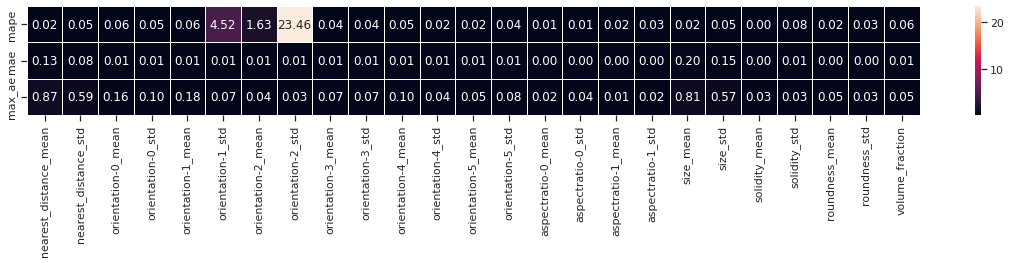

In [30]:
p = torch.Tensor(dm.scaler.inverse_transform(predictions))
t = torch.Tensor(dm.scaler.inverse_transform(targets))
mae = torch.mean(torch.abs(p - t), axis=0)
mape = torch.mean(torch.abs((p - t) / t), axis=0)
max_ae = torch.max(torch.abs(p - t), axis=0).values

data = pd.DataFrame.from_dict(
    {"mape": mape, "mae": mae, "max_ae": max_ae},
    columns=dm.train_df.columns[1:-1],
    dtype=float,
    orient="index",
)

fig = plt.figure(figsize=(20, 2))
sns.heatmap(
    data,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<Figure size 7200x7200 with 0 Axes>

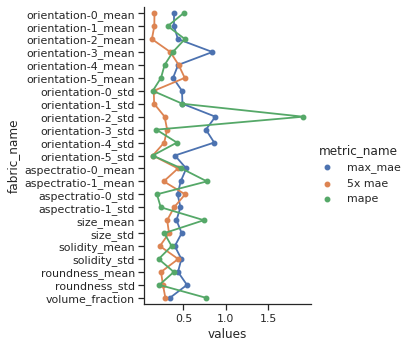

In [9]:
mae_df = pd.DataFrame(5 * mae, columns=["values"])
mae_df["metric_name"] = "5x mae"
mae_df["fabric_name"] = dm.train_df.columns[1:-1]
mape_df = pd.DataFrame(mape, columns=["values"])
mape_df["metric_name"] = "mape"
mape_df["fabric_name"] = dm.train_df.columns[1:-1]
max_ae_df = pd.DataFrame(max_ae, columns=["values"])
max_ae_df["metric_name"] = "max_mae"
max_ae_df["fabric_name"] = dm.train_df.columns[1:-1]

data = pd.concat([max_ae_df, mae_df, mape_df])
fig = plt.figure(figsize=(100, 100))
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.catplot(data=data, y="fabric_name", x="values", hue="metric_name", kind="point")
